In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src")
from utils.common.pathManager import FilePath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import trange, tqdm

In [2]:
from preprocessing.prepare_folder.create_label_masks import create_masks
from preprocessing.raw.gready_samp import gready_split_dataset

xbd_path = FilePath("/media/mrtc101/Martín SSD/tesis/datasets/xBD")
data_path = FilePath("/home/mrtc101/Desktop/tesina/repo/main/")
split_prop = {"train": 0.9, "test": 0.1}
total_tiles = 1111
create_masks(xbd_path)
tile_splits_json_path = gready_split_dataset(xbd_path, data_path, total_tiles, split_prop)

100%|██████████| 6095/6095 [00:03<00:00, 1935.22it/s]


In [3]:
tile_splits_json_path

'/home/mrtc101/Desktop/tesina/repo/main/splits/raw_splits.json'

# Gready

$$ \text{min}(\text{Var}(S_1,S_2,S_3,S_4) =  \frac{1}{n}\sum_{i=1}^{4}{(S_i - \bar{S})^2})$$

In [4]:
from preprocessing.raw.gready_samp import greedy_sampling

final_set = greedy_sampling(xbd_path,1111)

100%|██████████| 6095/6095 [00:02<00:00, 2063.45it/s]


In [5]:
table = final_set.groupby("dis_id").apply(lambda x : x.sum(axis=0), include_groups=False).drop("tile_id", axis=1)
row_sum = table.sum(axis=1)
col_sum = table.sum(axis=0)
col_sum.loc["Total"] = row_sum.sum()
table["Total"] = row_sum
table.loc["Total"] = col_sum
table

,destroyed,major-damage,minor-damage,no-damage,un-classified,Total
dis_id,,,,,,
guatemala-volcano,0,0,2,42,1,45
hurricane-florence,29,13,16,661,126,845
hurricane-harvey,380,9535,1912,645,129,12601
hurricane-matthew,701,1225,8107,692,293,11018
hurricane-michael,138,251,875,1221,35,2520
joplin-tornado,2184,470,645,634,116,4049
lower-puna-volcano,114,0,4,236,72,426
mexico-earthquake,0,0,0,40,17,57
midwest-flooding,19,22,33,576,30,680


In [6]:
print(table.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
 & destroyed & major-damage & minor-damage & no-damage & un-classified & Total \\
dis_id &  &  &  &  &  &  \\
\midrule
guatemala-volcano & 0 & 0 & 2 & 42 & 1 & 45 \\
hurricane-florence & 29 & 13 & 16 & 661 & 126 & 845 \\
hurricane-harvey & 380 & 9535 & 1912 & 645 & 129 & 12601 \\
hurricane-matthew & 701 & 1225 & 8107 & 692 & 293 & 11018 \\
hurricane-michael & 138 & 251 & 875 & 1221 & 35 & 2520 \\
joplin-tornado & 2184 & 470 & 645 & 634 & 116 & 4049 \\
lower-puna-volcano & 114 & 0 & 4 & 236 & 72 & 426 \\
mexico-earthquake & 0 & 0 & 0 & 40 & 17 & 57 \\
midwest-flooding & 19 & 22 & 33 & 576 & 30 & 680 \\
moore-tornado & 898 & 168 & 182 & 387 & 58 & 1693 \\
nepal-flooding & 23 & 770 & 505 & 534 & 62 & 1894 \\
palu-tsunami & 2958 & 272 & 1 & 1776 & 82 & 5089 \\
pinery-bushfire & 38 & 13 & 11 & 730 & 63 & 855 \\
portugal-wildfire & 205 & 49 & 20 & 1350 & 120 & 1744 \\
santa-rosa-wildfire & 3596 & 28 & 29 & 914 & 21 & 4588 \\
socal-fire & 606 & 14 & 14 & 1198

In [10]:
print(final_set.value_counts("dis_id").to_latex())

\begin{tabular}{lr}
\toprule
 & count \\
dis_id &  \\
\midrule
portugal-wildfire & 149 \\
socal-fire & 121 \\
hurricane-harvey & 106 \\
pinery-bushfire & 89 \\
woolsey-fire & 85 \\
santa-rosa-wildfire & 81 \\
hurricane-florence & 77 \\
midwest-flooding & 69 \\
hurricane-matthew & 55 \\
hurricane-michael & 54 \\
palu-tsunami & 44 \\
joplin-tornado & 36 \\
tuscaloosa-tornado & 35 \\
nepal-flooding & 30 \\
lower-puna-volcano & 29 \\
moore-tornado & 26 \\
sunda-tsunami & 15 \\
mexico-earthquake & 5 \\
guatemala-volcano & 5 \\
\bottomrule
\end{tabular}



NameError: name 'balanced' is not defined

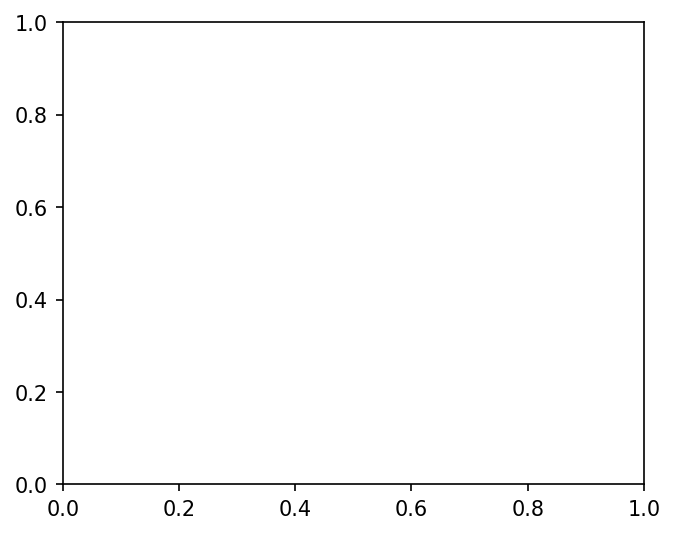

In [11]:
import matplotlib.pyplot as plt

width = 0.8  # the width of the bars
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150)

labels = ['destroyed', 'major-damage', 'minor-damage', 'no-damage', 'un-classified']
y_values = [balanced.loc["Total", label] for label in labels]

for label, y in zip(labels, y_values):
    bar = ax.bar(label, y, width);
    ax.text(label, y / 2, f'{y:.0f}', ha='center', va='bottom');

ax.set_yscale('log')
ax.set_ylim(10**3, 10**5.6)
#ax.set_ylabel('Total buildings')
#_ = ax.set_title('xBD dataset building class distribution')
ax.set_ylabel('Total edificios')
_ = ax.set_title('Distribución de edificios por tipo de daño')
_ = ax.set_xticks(list(range(len(labels))))
_ = ax.set_xticklabels(labels, rotation=45)

In [ ]:
samp_df : pd.DataFrame = dmg_by_tile_df.copy()
samp_df

,dis_id,tile_id,destroyed,major-damage,minor-damage,no-damage,un-classified
0,guatemala-volcano,00000004,4,8,6,2,0
1,guatemala-volcano,00000012,0,0,0,33,0
2,guatemala-volcano,00000014,1,5,0,0,1
3,guatemala-volcano,00000020,0,0,8,27,1
4,guatemala-volcano,00000022,2,1,0,4,0
...,...,...,...,...,...,...,...
11029,santa-rosa-wildfire,00000152,8,0,1,0,1
11030,santa-rosa-wildfire,00000153,0,0,0,53,0
11031,santa-rosa-wildfire,00000155,203,0,1,84,0
11032,santa-rosa-wildfire,00000156,0,0,0,65,0


In [ ]:
labels = ["destroyed", "major-damage", "minor-damage", "no-damage", "un-classified"]
dmg_by_tile_df: pd.DataFrame = create_bld_dmg_dataframe(xbd_path, labels)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:43<00:00, 10.83s/it]


In [ ]:
from utils.common.pathManager import FilePath
import math
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import sys
sys.path.append("../src")


def normalize_array(x):
    """Normalize a numpy array to the range [0, 1]."""
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min)


def find_best_sample(non_empty_df, empty_df, total_img: int, labels: list, balance_imp=0.7, empty_prop=0.2):
    """ Looks for the sample with size n with most building amount
    """

    if total_img > len(non_empty_df):
        raise ValueError(
            "El tamaño de la muestra no puede ser mayor que la longitud del DataFrame.")

    empty_size = math.floor(total_img * empty_prop)
    dmg_size = total_img - empty_size

    bld_tot_f = []
    imbalance_f = []
    for i in trange(0, len(non_empty_df)-dmg_size):
        sample = non_empty_df.iloc[i:i+dmg_size]
        bld_tot = sample.sum(axis=0, numeric_only=True).sum()
        arr = sample[labels].sum(axis=0, numeric_only=True).to_numpy()
        imbalance = mean_square_error(np.array([arr]))[0]
        bld_tot_f.append(bld_tot)
        imbalance_f.append(imbalance)

    norm_bld_tot = normalize_array(np.array(bld_tot_f))
    norm_imbalance = normalize_array(np.array(imbalance_f))
    beta = 100 * balance_imp  # Peso para f1
    alpha = 100 - beta   # Peso para f2
    combined_func = alpha * norm_bld_tot - beta * norm_imbalance
    norm_g = normalize_array(combined_func)
    id = norm_g.argmax()
    print(f"Índice de inicio: {id}, Índice de fin: {id + dmg_size}")

    dmg_sample = non_empty_df.iloc[id:id+dmg_size]
    dmg_sample = dmg_sample.reset_index()
    proportions = dmg_sample.value_counts("dis_id")
    proportions = proportions / proportions.sum()
    img_num_by_dis = (empty_size * proportions).apply(lambda x: round(x))

    empty_sample = empty_df.reset_index(drop=True)
    empty_sample = empty_df.groupby(["dis_id"]).apply(
        lambda x: x.sample(n=img_num_by_dis[x.name], replace=True),
        include_groups=False)
    empty_sample :pd.DataFrame = empty_sample.reset_index()
    empty_sample.drop(columns=["level_1"], inplace=True)
    return pd.concat([dmg_sample, empty_sample], axis=0)


def mean_square_error(matrix_arr: np.ndarray) -> np.ndarray:
    """Function that calculates the variation of the given series"""
    matrix_arr: np.ndarray = matrix_arr.astype(float)
    matrix_arr -= matrix_arr.mean(axis=1)[:, np.newaxis]
    matrix_arr = matrix_arr**2
    return matrix_arr.sum(axis=1) / matrix_arr.shape[1]


def get_best_candidate(candidates_df: pd.DataFrame, total_arr: np.ndarray) -> pd.DataFrame:
    """The variation of the sum of buildings per class is computed"""
    cand_matrix: np.ndarray = candidates_df.to_numpy(copy=True)
    cand_matrix += total_arr
    points = mean_square_error(cand_matrix) - mean_square_error(np.array([total_arr]))
    return candidates_df.iloc[points.argmin()].name


def sort_by_imbalance(df: pd.DataFrame, labels: list) -> pd.DataFrame:
    """Builds a size n deterministic sample of images in a way that the resulting sample is as balanced as posible."""
    index = []
    df = df.set_index(["dis_id", "tile_id"])
    curr_sample = df[labels].copy()
    total_per_label = np.zeros(len(labels), dtype=np.int64)
    for _ in trange(len(df), desc='Sorting index'):
        best_id = get_best_candidate(curr_sample, total_per_label)
        total_per_label += curr_sample.loc[best_id].to_numpy(copy=True)
        curr_sample.drop(index=best_id, inplace=True)
        index.append(best_id)
    return df.loc[index]


def create_bld_dmg_dataframe(xbd_path: FilePath, labels: list) -> pd.DataFrame:
    """
    This method iterates over each 'labels' folder and creates a pandas DataFrame 
    containing the count of buildings by damage type for each image in the xBD dataset.

    Args:
        xbd_path (FilePath): string path to the xBD dataset folder. 
        labels (list): List of string damage labels to be count.

    Returns:
        pd.Dataframe : The number of buildings of each image by damage label.
    """
    tiles = []
    # iterates over labels directories
    for split_folder in tqdm(xbd_path.get_folder_paths()):
        folder_path = split_folder.join("labels")
        for json_name in folder_path.get_files_names():
            name_splits = json_name.split("_")
            dis_id, tile_id, time_prefix = name_splits[:3]
            # only count post disaster images.
            if time_prefix == "post":
                label_dict = folder_path.join(json_name).read_json()
                label_count = pd.Series(data=np.zeros(5, dtype=np.uint16), index=labels)
                for building in label_dict['features']['xy']:
                    dmg_label = building['properties'].get('subtype')
                    if dmg_label in label_count.index:
                        label_count[dmg_label] += 1

                row = [dis_id, tile_id] + label_count.tolist()
                tiles.append(row)

    dmg_by_tile_df = pd.DataFrame(tiles, columns=["dis_id", "tile_id"] + labels)
    return dmg_by_tile_df


def split_empty_images(dmg_by_tile_df, columns):
    non_empty_idx = dmg_by_tile_df[columns].sum(axis=1) != 0
    non_empty_df = dmg_by_tile_df.loc[non_empty_idx]
    empty_df = dmg_by_tile_df.loc[~non_empty_idx]
    return non_empty_df, empty_df


def greedy_sampling(xbd_path: FilePath, data_path: FilePath, img_num: int) -> FilePath:
    labels = ["destroyed", "major-damage", "minor-damage", "no-damage", "un-classified"]
    # dmg_by_tile_df: pd.DataFrame = create_bld_dmg_dataframe(xbd_path, labels)

    # Filtrar las columnas relacionadas con los daños, excluyendo las filas vacías
    non_empty_df, empty_df = split_empty_images(dmg_by_tile_df, labels[:4])
    non_empty_df = sort_by_imbalance(non_empty_df, labels[:4])
    sample = find_best_sample(non_empty_df, empty_df, img_num, labels[:4])
    return sample
    # path_dict = build_path_dict(xbd_path, sample)
    # tile_splits_json_path = data_path.join("splits").join("raw_splits.json").save_json(path_dict)
    # return tile_splits_json_path


xbd_path = FilePath("/media/mrtc101/Martín SSD/tesis/datasets/xBD")
sample = greedy_sampling(xbd_path, FilePath(""), 1111)

100%|██████████| 6095/6095 [00:07<00:00, 862.27it/s]


Índice de inicio: 3217, Índice de fin: 4106


In [ ]:
sample.describe()

,destroyed,major-damage,minor-damage,no-damage,un-classified
count,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000
mean,11.293429,11.626463,11.501350,11.884788,1.802880
std,36.737176,39.707148,49.470655,18.484307,7.090778
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,9.000000,0.000000
75%,3.000000,1.000000,1.000000,13.000000,1.000000
max,511.000000,441.000000,519.000000,222.000000,92.000000
